In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from models.model import ScikitlearnClassifierSVC
from poisoning import PoisoningAttackSVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

DATA_DIR = './train'
CLASSES = ['0', '1', '2']
IMG_SIZE = (32, 32) 

X = []
y = []

for class_label in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_label)
    for fname in sorted(os.listdir(class_dir)): 
        if fname.endswith('.png'):
            img_path = os.path.join(class_dir, fname)
            img = Image.open(img_path).resize(IMG_SIZE).convert('RGB')
            img_array = np.array(img).flatten() 
            X.append(img_array)
            y.append(int(class_label))

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)

indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

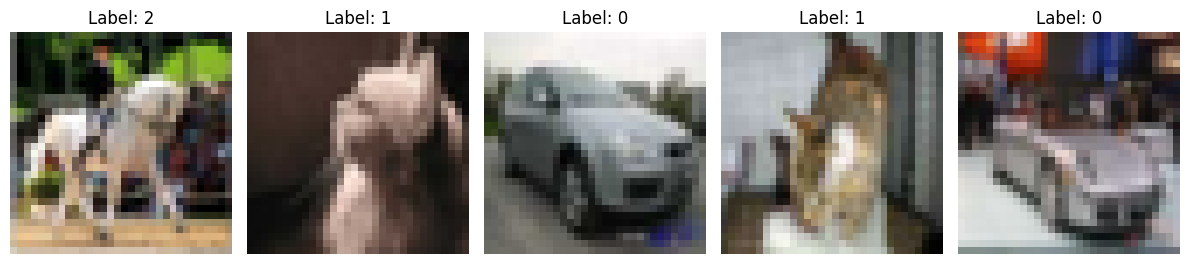

In [2]:
num_images = 5
random_indices = np.random.choice(len(X), size=num_images, replace=False)

fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X[idx].reshape(32, 32, 3))
    ax.axis('off')
    ax.set_title(f'Label: {y[idx]}')
plt.tight_layout()
plt.show()

In [ ]:
target_class1=1
target_class2=2

perm1 = np.random.permutation(len(X))
X = X[perm1]
y = y[perm1]

target_class1_xdata=X[y==target_class1]
target_class2_xdata=X[y==target_class2]
target_class1_ydata=y[y==target_class1]
target_class2_ydata=y[y==target_class2]

X_train=np.concatenate([target_class1_xdata[:100],target_class2_xdata[:100]],axis=0)
y_train=np.concatenate([target_class1_ydata[:100],target_class2_ydata[:100]],axis=0)
X_val=np.concatenate([target_class1_xdata[100:500],target_class2_xdata[100:500]],axis=0)
y_val=np.concatenate([target_class1_ydata[100:500],target_class2_ydata[100:500]],axis=0)
X_test=np.concatenate([target_class1_xdata[500:2500],target_class2_xdata[500:2500]],axis=0)
y_test=np.concatenate([target_class1_ydata[500:2500],target_class2_ydata[500:2500]],axis=0)

In [5]:
perm1 = np.random.permutation(X_train.shape[0])
perm2= np.random.permutation(X_val.shape[0])
perm3= np.random.permutation(X_test.shape[0])

X_train=X_train[perm1]
X_val=X_val[perm2]
X_test=X_test[perm3]

y_train=y_train[perm1]
y_val=y_val[perm2]
y_test=y_test[perm3]

In [ ]:
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 66.22%


In [8]:
unique_classes = np.unique(y_train)
nb_samples = len(y_train)
nb_classes = len(unique_classes)
nb_samples_val=len(y_val)

y_train_ohe = np.zeros((nb_samples, nb_classes))
y_val_ohe=np.zeros((nb_samples_val, nb_classes))

for i, label in enumerate(y_train):
    class_index = np.where(unique_classes == label)[0][0]
    y_train_ohe[i, class_index] = 1
for i, label in enumerate(y_val):
    class_index = np.where(unique_classes == label)[0][0]
    y_val_ohe[i, class_index] = 1

In [9]:
def get_adversarial_examples(x_train, y_train, attack_idx, x_val, y_val, kernel):
    attack_classifier = ScikitlearnClassifierSVC(model=SVC(kernel=kernel),clip_values=(0,255),nb_classes=nb_classes)
    attack_classifier.fit(x_train, y_train)
    init_attack = np.copy(x_train[attack_idx])
    y_attack = np.array([1, 1]) - np.copy(y_train[attack_idx])
    attack = PoisoningAttackSVM(attack_classifier, 0.01, 1.0, x_train, y_train, x_val, y_val, max_iter=10)
    x_attack, y_attack = attack.poison(np.array([init_attack]), y=np.array([y_attack]))
    return x_attack,y_attack
       

def save_single_poisoned_image(img, label, index, save_dir="./poisoned"):
    if img.ndim == 1 and img.shape[0] == 3072:
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)
    
    if img.dtype in [np.float32, np.float64]:
        img = img.clip(0, 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    filename = f"{label}_{index}.png"
    img_pil.save(os.path.join(save_dir, filename))

In [ ]:
num_poisoned_samples=5
x_poison=X_train
y_poison=y_train

from concurrent.futures import ProcessPoolExecutor, as_completed
import numpy as np

def generate_single_attack(attack_idx):
    x_attackpoint, y_attackpoint = get_adversarial_examples(X_train, y_train_ohe, attack_idx, X_test, y_val_ohe, "linear")
    id_array = np.argmax(y_attackpoint, axis=1)
    y_attackpoint = np.where(id_array == 0, target_class1, target_class2)
    
    save_single_poisoned_image(x_attackpoint[0], y_attackpoint[0], attack_idx)
    
    return x_attackpoint, y_attackpoint

x_poison_list = []
y_poison_list = []

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(generate_single_attack, attack_idx) for attack_idx in range(num_poisoned_samples)]
    
    for future in as_completed(futures):
        x_attackpoint, y_attackpoint = future.result()
        x_poison_list.append(x_attackpoint)
        y_poison_list.append(y_attackpoint)

x_poison = np.concatenate(x_poison_list, axis=0)
y_poison = np.concatenate(y_poison_list, axis=0)

In [ ]:
svm_clf2 = SVC(kernel='linear', C=1.0, random_state=42, max_iter=10000)
svm_clf2.fit(np.concatenate((X_train, x_poison), axis=0), np.concatenate((y_train, y_poison), axis=0))
y_pred2 = svm_clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Poisoned Accuracy: {:.2%}".format(accuracy))

svm_clf2 = SVC(kernel='linear', C=1.0, random_state=42, max_iter=10000)
svm_clf2.fit(X_train, y_train)
y_pred2 = svm_clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Original Accuracy: {:.2%}".format(accuracy))

class_1_indices = np.where(y_val == 1)[0]
x_val_class_1 = X_val[class_1_indices]
y_val_class_1 = y_val[class_1_indices]
selected_indices = np.random.choice(len(x_val_class_1), size=200, replace=False)
x_val_flipped = x_val_class_1[selected_indices]
y_val_flipped = y_val_class_1[selected_indices]
y_val_flipped[:] = 2
X_train_with_poison = np.concatenate((X_train, x_val_flipped), axis=0)
y_train_with_poison = np.concatenate((y_train, y_val_flipped), axis=0)
svm_clf2 = SVC(kernel='linear', C=1.0, random_state=42)
svm_clf2.fit(X_train_with_poison, y_train_with_poison)
y_pred2 = svm_clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Basic Poisoning Accuracy: {:.2%}".format(accuracy))

Poisoned Accuracy: 61.82%
Original Accuracy: 66.22%
Basic Poisoning Accuracy: 55.25%
